#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from catboost import CatBoostClassifier

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

* 함수 생성

In [3]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [4]:
os.getcwd()

'c:\\Users\\suyeo\\OneDrive\\바탕 화면\\AI+X_중급\\실습파일'

In [5]:
#전체 데이터 불러오기
file = r'../data/data01_test.csv'
new_data = pd.read_csv(file)
new_data.drop('subject',axis=1,inplace=True)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [6]:
#전체 데이터 불러오기
file = r'../data/data01_train.csv'
data = pd.read_csv(file)
data.drop('subject',axis=1,inplace=True) #비식별화 (개별 피험자에게 관심 있는 것이 아님)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [7]:
data.shape

(5881, 562)

#### 2) 기본 정보 조회

In [8]:
#전체 데이터의 행,열 개수 확인
n_rows, n_cols = data.shape

print("행 개수:", n_rows)
print("열 개수:", n_cols)

행 개수: 5881
열 개수: 562


In [9]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [10]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다. 


- NaN 값 확인하기

In [11]:
# NaN 값이 있는지 확인
print("NaN 값이 있는지 여부 (True/False):")
print(data.isnull().any())  # 각 열에 NaN 값이 있는지 확인

# NaN 값의 개수 확인
print("\nNaN 값의 개수:")
print(data.isnull().sum())  # 각 열의 NaN 값 개수 확인

# 전체 데이터프레임에 NaN이 하나라도 존재하는지 여부 확인
print("\n전체 데이터에 NaN 값이 있는지 여부:")
print(data.isnull().values.any())

NaN 값이 있는지 여부 (True/False):
tBodyAcc-mean()-X                       False
tBodyAcc-mean()-Y                       False
tBodyAcc-mean()-Z                       False
tBodyAcc-std()-X                        False
tBodyAcc-std()-Y                        False
                                        ...  
angle(tBodyGyroJerkMean,gravityMean)    False
angle(X,gravityMean)                    False
angle(Y,gravityMean)                    False
angle(Z,gravityMean)                    False
Activity                                False
Length: 562, dtype: bool

NaN 값의 개수:
tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity 

### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [15]:
# # 'Activity' 열을 정적(0)/동적(1)으로 매핑
# activity_mapping = {'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1, 
#                     'LAYING': 0, 'STANDING': 0, 'SITTING': 0}

In [16]:
data['Activity_num']=data['Activity'].map({'WALKING':0,'WALKING_UPSTAIRS':1,'WALKING_DOWNSTAIRS':2,'LAYING':3,'STANDING':4,'SITTING':5})

In [17]:
# data['Activity'] = data['Activity'].map(activity_mapping)

# 입력(X)와 출력(y) 분리
X = data.drop(['Activity','Activity_num'], axis=1)
y = data['Activity_num']

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [20]:
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : XGBoost

In [25]:
N = 30

In [26]:
# new_data['Activity_num']=new_data['Activity'].map({'WALKING':0,'WALKING_UPSTAIRS':1,'WALKING_DOWNSTAIRS':2,'LAYING':3,'STANDING':4,'SITTING':5})
# # data['Activity'] = data['Activity'].map(activity_mapping)

# # 입력(X)와 출력(y) 분리
# X = new_data.drop(['Activity','Activity_num'], axis=1)
# y = new_data['Activity_num']
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# y_pred = xgb_model.predict(X_scaled)
# accuracy = accuracy_score(y, y_pred)
# # conf_matrix = confusion_matrix(y_val, y_pred)

# # 정확도 출력
# print(f"XGBoost 모델의 정확도 (전체 변수): {accuracy:.4f}")

In [35]:
# ------------------- 전체 변수로 모델링 -------------------

# XGBoost 모델 학습 - 전체 변수 사용
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)


# 예측 및 성능 평가 - 전체 변수 사용
y_pred = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, y_pred)
xgb_conf_matrix = confusion_matrix(y_val, y_pred)
xgb_f1_score = f1_score(y_val, y_pred, average='weighted')  # 'weighted'는 다중 분류일 경우 가중 평균을 구합니다

# 결과 출력
print(f"XGBoost 모델의 정확도 (전체 변수): {xgb_accuracy:.4f}")
print(classification_report(y_val, y_pred))


XGBoost 모델의 정확도 (전체 변수): 0.9932
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       198
           1       0.99      1.00      0.99       177
           2       0.99      0.99      0.99       145
           3       1.00      1.00      1.00       231
           4       1.00      0.99      0.99       226
           5       0.99      0.99      0.99       200

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [36]:
# --------- XGBoost로 변수 중요도 계산 후 상위 N개 변수 선택 --------------

# 변수 중요도 계산
importance = xgb_model.feature_importances_

# 중요도 순으로 상위 N개의 변수 선택
indices = np.argsort(importance)[::-1][:N]

# 상위 N개의 변수 선택
X_train_selected = X_train[:, indices]
X_val_selected = X_val[:, indices]

# XGBoost 모델 학습 - 상위 N개 변수 사용
xgb_model_selected = XGBClassifier(random_state=42)
xgb_model_selected.fit(X_train_selected, y_train)

# 예측 및 성능 평가 - 상위 N개 변수 사용
y_pred_selected = xgb_model_selected.predict(X_val_selected)
xgb_accuracy_selected = accuracy_score(y_val, y_pred_selected)
xgb_conf_matrix_selected = confusion_matrix(y_val, y_pred_selected)
xgb_f1_score_selected = f1_score(y_val, y_pred_selected, average='weighted')

# 결과 출력
print(f"XGBoost 모델의 정확도 (상위 {N}개 변수): {xgb_accuracy_selected:.4f}")
print(classification_report(y_val, y_pred_selected))

XGBoost 모델의 정확도 (상위 30개 변수): 0.9796
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       198
           1       0.98      0.99      0.99       177
           2       0.98      0.97      0.98       145
           3       1.00      1.00      1.00       231
           4       0.98      0.96      0.97       226
           5       0.95      0.98      0.97       200

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



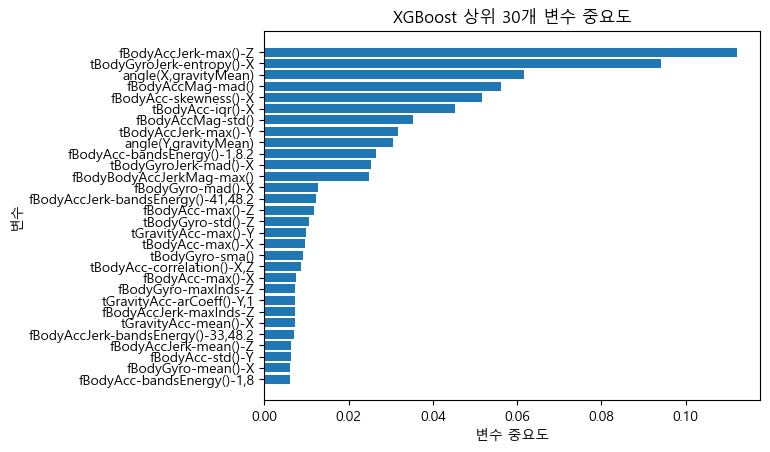

In [37]:
# 상위 N개의 변수 중요도 시각화
plt.barh(np.arange(N), importance[indices][::-1])
plt.yticks(np.arange(N), np.array(X.columns)[indices][::-1])
plt.xlabel('변수 중요도')
plt.ylabel('변수')
plt.title(f'XGBoost 상위 {N}개 변수 중요도')
plt.show()

In [38]:
model_performance_df = pd.DataFrame(columns=['Model', 'Accuracy', 'f1_score'])

# 성능 데이터프레임에 XGBoost 모델 결과 추가
model_performance_df = model_performance_df.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_accuracy,
    'f1_score': xgb_f1_score
}, ignore_index=True)

model_performance_df_selected = pd.DataFrame(columns=['Model', 'Accuracy', 'f1_score'])

# 성능 데이터프레임에 XGBoost 모델 결과 추가
model_performance_df_selected = model_performance_df_selected.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_accuracy_selected,
    'f1_score': xgb_f1_score_selected
}, ignore_index=True)

C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\1924072672.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append({
C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\1924072672.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df_selected = model_performance_df_selected.append({


### (2) 알고리즘2 : RandomForest

In [39]:
# ------------------- 전체 변수로 모델링 -------------------

# RandomForest 모델 학습 - 전체 변수 사용
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가 - 전체 변수 사용
y_pred_rf = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_conf_matrix = confusion_matrix(y_val, y_pred_rf)
rf_f1_score = f1_score(y_val, y_pred_rf, average='weighted')

# 결과 출력
print(f"RandomForest 모델의 정확도 (전체 변수): {rf_accuracy:.4f}")
print(f"RandomForest 모델의 F1 스코어 (전체 변수): {rf_f1_score:.4f}")
print(classification_report(y_val, y_pred_rf))

RandomForest 모델의 정확도 (전체 변수): 0.9813
RandomForest 모델의 F1 스코어 (전체 변수): 0.9813
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       198
           1       0.98      0.98      0.98       177
           2       0.97      0.98      0.98       145
           3       1.00      1.00      1.00       231
           4       0.98      0.96      0.97       226
           5       0.96      0.98      0.97       200

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [40]:
# ------------------- RandomForest로 변수 중요도 계산 후 상위 N개 변수 선택 -------------------

# 변수 중요도 계산
rf_importance = rf_model.feature_importances_

# 중요도 순으로 상위 N개의 변수 선택
rf_indices = np.argsort(rf_importance)[::-1][:N]

# 상위 N개의 변수 선택
X_train_selected_rf = X_train[:, rf_indices]
X_val_selected_rf = X_val[:, rf_indices]

# RandomForest 모델 학습 - 상위 N개 변수 사용
rf_model_selected = RandomForestClassifier(random_state=42)
rf_model_selected.fit(X_train_selected_rf, y_train)

# 예측 및 성능 평가 - 상위 N개 변수 사용
y_pred_rf_selected = rf_model_selected.predict(X_val_selected_rf)
rf_accuracy_selected = accuracy_score(y_val, y_pred_rf_selected)
rf_f1_score_selected = f1_score(y_val, y_pred_rf_selected, average='weighted')

# 결과 출력
print(f"RandomForest 모델의 정확도 (상위 {N}개 변수): {rf_accuracy_selected:.4f}")
print(f"RandomForest 모델의 F1 스코어 (상위 {N}개 변수): {rf_f1_score_selected:.4f}")
print(classification_report(y_val, y_pred_rf_selected))

RandomForest 모델의 정확도 (상위 30개 변수): 0.9762
RandomForest 모델의 F1 스코어 (상위 30개 변수): 0.9762
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       198
           1       0.97      0.97      0.97       177
           2       0.96      0.95      0.96       145
           3       1.00      1.00      1.00       231
           4       0.99      0.96      0.98       226
           5       0.96      0.99      0.97       200

    accuracy                           0.98      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.98      0.98      0.98      1177



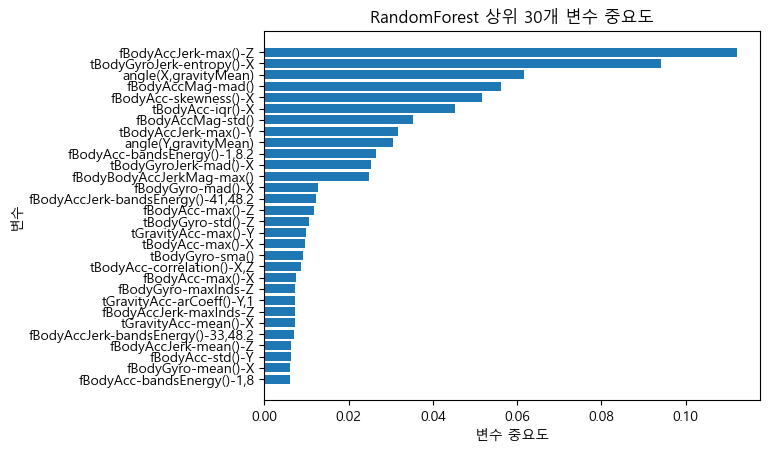

In [41]:
# 상위 N개의 변수 중요도 시각화
plt.barh(np.arange(N), importance[indices][::-1])
plt.yticks(np.arange(N), np.array(X.columns)[indices][::-1])
plt.xlabel('변수 중요도')
plt.ylabel('변수')
plt.title(f'RandomForest 상위 {N}개 변수 중요도')
plt.show()

In [42]:
# 성능 데이터프레임에 RandomForest 모델 결과 추가
model_performance_df = model_performance_df.append({
    'Model': 'RandomForest',
    'Accuracy': rf_accuracy,
    'f1_score': rf_f1_score
}, ignore_index=True)

# 성능 데이터프레임에 RandomForest 모델 결과 추가 (상위 N개 변수 사용)
model_performance_df_selected = model_performance_df_selected.append({
    'Model': 'RandomForest',
    'Accuracy': rf_accuracy_selected,
    'f1_score': rf_f1_score_selected
}, ignore_index=True)

C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\2922339118.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append({
C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\2922339118.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df_selected = model_performance_df_selected.append({


### (3) 알고리즘3 : LightGBM

In [43]:
# ------------------- 전체 변수로 모델링 -------------------

# LightGBM 모델 학습 - 전체 변수 사용
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# 예측 및 성능 평가 - 전체 변수 사용
y_pred_lgb = lgb_model.predict(X_val)
lgb_accuracy = accuracy_score(y_val, y_pred_lgb)
lgb_conf_matrix = confusion_matrix(y_val, y_pred_lgb)
lgb_f1_score = f1_score(y_val, y_pred_lgb, average='weighted')

# 결과 출력
print(f"LightGBM 모델의 정확도 (전체 변수): {lgb_accuracy:.4f}")
print(f"LightGBM 모델의 F1 스코어 (전체 변수): {lgb_f1_score:.4f}")
print(classification_report(y_val, y_pred_lgb))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140145
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] Start training from score -1.771557
[LightGBM] [Info] Start training from score -1.932606
[LightGBM] [Info] Start training from score -1.985369
[LightGBM] [Info] Start training from score -1.671711
[LightGBM] [Info] Start training from score -1.698074
[LightGBM] [Info] Start training from score -1.732336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [44]:
# ------------------- LightGBM로 변수 중요도 계산 후 상위 N개 변수 선택 -------------------

# 변수 중요도 계산
lgb_importance = lgb_model.feature_importances_

# 중요도 순으로 상위 N개의 변수 선택
lgb_indices = np.argsort(lgb_importance)[::-1][:N]

# 상위 N개의 변수 선택
X_train_selected_lgb = X_train[:, lgb_indices]
X_val_selected_lgb = X_val[:, lgb_indices]

# LightGBM 모델 학습 - 상위 N개 변수 사용
lgb_model_selected = lgb.LGBMClassifier(random_state=42)
lgb_model_selected.fit(X_train_selected_lgb, y_train)

# 예측 및 성능 평가 - 상위 N개 변수 사용
y_pred_lgb_selected = lgb_model_selected.predict(X_val_selected_lgb)
lgb_accuracy_selected = accuracy_score(y_val, y_pred_lgb_selected)
lgb_f1_score_selected = f1_score(y_val, y_pred_lgb_selected, average='weighted')

# 결과 출력
print(f"LightGBM 모델의 정확도 (상위 {N}개 변수): {lgb_accuracy_selected:.4f}")
print(f"LightGBM 모델의 F1 스코어 (상위 {N}개 변수): {lgb_f1_score_selected:.4f}")
print(classification_report(y_val, y_pred_lgb_selected))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7418
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 30
[LightGBM] [Info] Start training from score -1.771557
[LightGBM] [Info] Start training from score -1.932606
[LightGBM] [Info] Start training from score -1.985369
[LightGBM] [Info] Start training from score -1.671711
[LightGBM] [Info] Start training from score -1.698074
[LightGBM] [Info] Start training from score -1.732336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

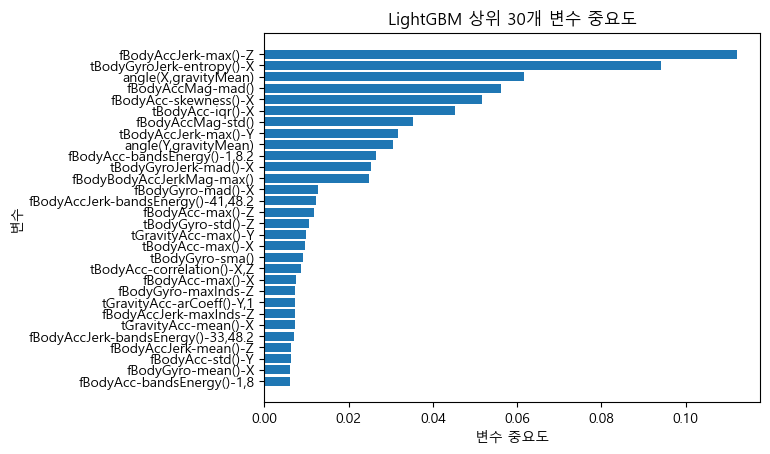

In [45]:
# 상위 N개의 변수 중요도 시각화
plt.barh(np.arange(N), importance[indices][::-1])
plt.yticks(np.arange(N), np.array(X.columns)[indices][::-1])
plt.xlabel('변수 중요도')
plt.ylabel('변수')
plt.title(f'LightGBM 상위 {N}개 변수 중요도')
plt.show()

In [50]:
# 성능 데이터프레임에 LightGBM 모델 결과 추가
model_performance_df = model_performance_df.append({
    'Model': 'LightGBM',
    'Accuracy': lgb_accuracy,
    'f1_score': lgb_f1_score
}, ignore_index=True)

# 성능 데이터프레임에 LightGBM 모델 결과 추가 (상위 N개 변수 사용)
model_performance_df_selected = model_performance_df_selected.append({
    'Model': 'LightGBM',
    'Accuracy': lgb_accuracy_selected,
    'f1_score': lgb_f1_score_selected
}, ignore_index=True)


C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\2247240726.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append({
C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\2247240726.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df_selected = model_performance_df_selected.append({


### (4) 알고리즘4 : CatBoost

In [48]:
# ------------------- 전체 변수로 모델링 -------------------

# CatBoost 모델 학습 - 전체 변수 사용
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# 예측 및 성능 평가 - 전체 변수 사용
y_pred_catboost = catboost_model.predict(X_val)
catboost_accuracy = accuracy_score(y_val, y_pred_catboost)
catboost_f1_score = f1_score(y_val, y_pred_catboost, average='weighted')

# 결과 출력
print(f"CatBoost 모델의 정확도 (전체 변수): {catboost_accuracy:.4f}")
print(f"CatBoost 모델의 F1 스코어 (전체 변수): {catboost_f1_score:.4f}")
print(classification_report(y_val, y_pred_catboost))

CatBoost 모델의 정확도 (전체 변수): 0.9932
CatBoost 모델의 F1 스코어 (전체 변수): 0.9932
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       198
           1       0.99      1.00      1.00       177
           2       1.00      1.00      1.00       145
           3       1.00      1.00      1.00       231
           4       0.99      0.98      0.98       226
           5       0.98      0.98      0.98       200

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [49]:
# ------------------- CatBoost로 변수 중요도 계산 후 상위 N개 변수 선택 -------------------

# 변수 중요도 계산
catboost_importance = catboost_model.get_feature_importance()

# 중요도 순으로 상위 N개의 변수 선택
catboost_indices = np.argsort(catboost_importance)[::-1][:N]

# 상위 N개의 변수 선택
X_train_selected_catboost = X_train[:, catboost_indices]
X_val_selected_catboost = X_val[:, catboost_indices]

# CatBoost 모델 학습 - 상위 N개 변수 사용
catboost_model_selected = CatBoostClassifier(random_state=42, verbose=0)
catboost_model_selected.fit(X_train_selected_catboost, y_train)

# 예측 및 성능 평가 - 상위 N개 변수 사용
y_pred_catboost_selected = catboost_model_selected.predict(X_val_selected_catboost)
catboost_accuracy_selected = accuracy_score(y_val, y_pred_catboost_selected)
catboost_f1_score_selected = f1_score(y_val, y_pred_catboost_selected, average='weighted')

# 결과 출력
print(f"CatBoost 모델의 정확도 (상위 {N}개 변수): {catboost_accuracy_selected:.4f}")
print(f"CatBoost 모델의 F1 스코어 (상위 {N}개 변수): {catboost_f1_score_selected:.4f}")
print(classification_report(y_val, y_pred_catboost_selected))

CatBoost 모델의 정확도 (상위 30개 변수): 0.9898
CatBoost 모델의 F1 스코어 (상위 30개 변수): 0.9898
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       198
           1       0.99      1.00      0.99       177
           2       1.00      0.99      0.99       145
           3       1.00      1.00      1.00       231
           4       0.99      0.97      0.98       226
           5       0.97      0.98      0.98       200

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



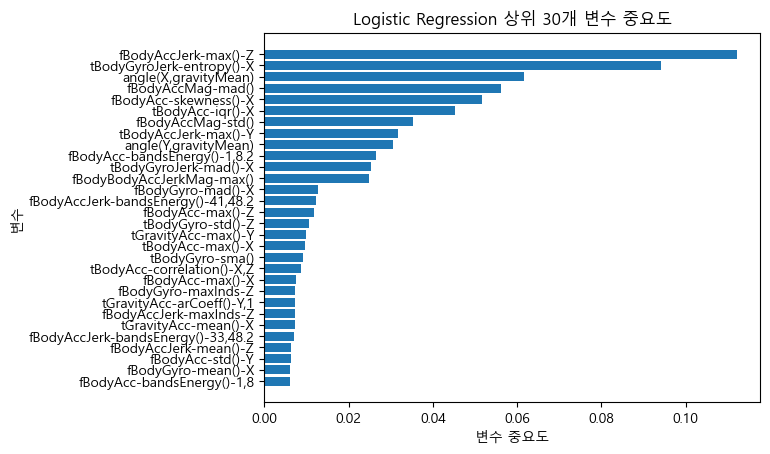

In [51]:
# 상위 N개의 변수 중요도 시각화
plt.barh(np.arange(N), importance[indices][::-1])
plt.yticks(np.arange(N), np.array(X.columns)[indices][::-1])
plt.xlabel('변수 중요도')
plt.ylabel('변수')
plt.title(f'Logistic Regression 상위 {N}개 변수 중요도')
plt.show()

In [52]:
# 성능 데이터프레임에 CatBoost 모델 결과 추가
model_performance_df = model_performance_df.append({
    'Model': 'CatBoost',
    'Accuracy': catboost_accuracy,
    'f1_score': catboost_f1_score
}, ignore_index=True)

# 성능 데이터프레임에 CatBoost 모델 결과 추가 (상위 N개 변수 사용)
model_performance_df_selected = model_performance_df_selected.append({
    'Model': 'CatBoost',
    'Accuracy': catboost_accuracy_selected,
    'f1_score': catboost_f1_score_selected
}, ignore_index=True)


C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\1963216643.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append({
C:\Users\suyeo\AppData\Local\Temp\ipykernel_9124\1963216643.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df_selected = model_performance_df_selected.append({


In [53]:
# 각각의 데이터프레임 출력
print("Model Performance - 전체 변수 사용:")
print(model_performance_df)

print("\nModel Performance - 상위 N개 변수 사용:")
print(model_performance_df_selected)

Model Performance - 전체 변수 사용:
          Model  Accuracy  f1_score
0       XGBoost  0.993203  0.993200
1  RandomForest  0.981308  0.981319
2      LightGBM  0.994902  0.994904
3      CatBoost  0.993203  0.993204

Model Performance - 상위 N개 변수 사용:
          Model  Accuracy  f1_score
0       XGBoost  0.979609  0.979607
1  RandomForest  0.976211  0.976210
2      LightGBM  0.989805  0.989795
3      CatBoost  0.989805  0.989806
